In [1]:
!git clone https://github.com/AlexandreNap/surf-crowd --recurse-submodules

Cloning into 'surf-crowd'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 360 (delta 44), reused 71 (delta 32), pack-reused 256
Receiving objects: 100% (360/360), 45.72 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Submodule 'surfers_detection/yolov5' (https://github.com/AlexandreNap/yolov5.git) registered for path 'surfers_detection/yolov5'
Cloning into '/kaggle/working/surf-crowd/surfers_detection/yolov5'...
remote: Enumerating objects: 12330, done.        
remote: Total 12330 (delta 0), reused 0 (delta 0), pack-reused 12330        
Receiving objects: 100% (12330/12330), 12.12 MiB | 5.79 MiB/s, done.
Resolving deltas: 100% (8474/8474), done.
Submodule path 'surfers_detection/yolov5': checked out 'c5f15168ee73fef02357fb147b6d1e55da14268e'


In [2]:
!pip install -r ./surf-crowd/surfers_detection/yolov5/requirements.txt

In [3]:
%cd ./surf-crowd/surfers_detection/yolov5

/kaggle/working/surf-crowd/surfers_detection/yolov5


In [4]:
%ls

CONTRIBUTING.md  aws_lambda/  hubconf.py         template_no_auth.yaml  val.py
Dockerfile       data/        models/            train.py
LICENSE          detect.py    requirements.txt*  tutorial.ipynb
README.md        export.py    setup.cfg          utils/


In [5]:
!pip install -qU wandb
#!pip install -qU bbox-utility

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.13.1 which is incompatible.


In [6]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys

from joblib import Parallel, delayed

from IPython.display import display

In [7]:
%mkdir data/surfers-detection

In [8]:
import yaml

data = dict(
    path  = 'data/surfers-detection/images/',
    train = 'train/',
    val   = 'val/',
    nc    = 1,
    names = ['surfer'],
    )

with open(os.path.join("./" , 'surfer.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join("./" , 'surfer.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- surfer
nc: 1
path: data/surfers-detection/images/
train: train/
val: val/



In [9]:
%cp -r ../../../../input/surfers-detection-640px/annotated/* ./data/surfers-detection/

In [10]:
ls data/surfers-detection

images/  labels/


In [11]:
%%writefile hyp.yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.08  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 12.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.33  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.03  # image HSV-Hue augmentation (fraction)
hsv_s: 0.3  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.2  # image HSV-Value augmentation (fraction)
degrees: 0.07  # image rotation (+/- deg)
translate: 0.08  # image translation (+/- fraction)
scale: 0.08  # image scale (+/- gain)
shear: 0.02  # image shear (+/- deg)
perspective: 0.0002  # image perspective (+/- fraction), range 0-0.001
flipud: 0.0  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.3  # image mosaic (probability)
mixup: 0.02 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

Writing hyp.yaml


In [12]:
!python train.py --train_imgsz 640 --val_imgsz 1920 --rect --batch 16 --epochs 120 --data surfer.yaml --weights yolov5l.pt --workers 0 --cache --hyp hyp.yaml

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5l.pt, cfg=, data=surfer.yaml, hyp=hyp.yaml, epochs=120, batch_size=16, train_imgsz=640, val_imgsz=1920, rect=True, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/AlexandreNap/yolov5 ✅
YOLOv5 🚀 2022-8-19 Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.08, momentum=0.937, weight_decay=0.0005,

In [13]:
%ls

CONTRIBUTING.md  data/       requirements.txt*      tutorial.ipynb
Dockerfile       detect.py   runs/                  utils/
LICENSE          export.py   setup.cfg              val.py
README.md        hubconf.py  surfer.yaml            yolov5l.pt
__pycache__/     hyp.yaml    template_no_auth.yaml
aws_lambda/      models/     train.py


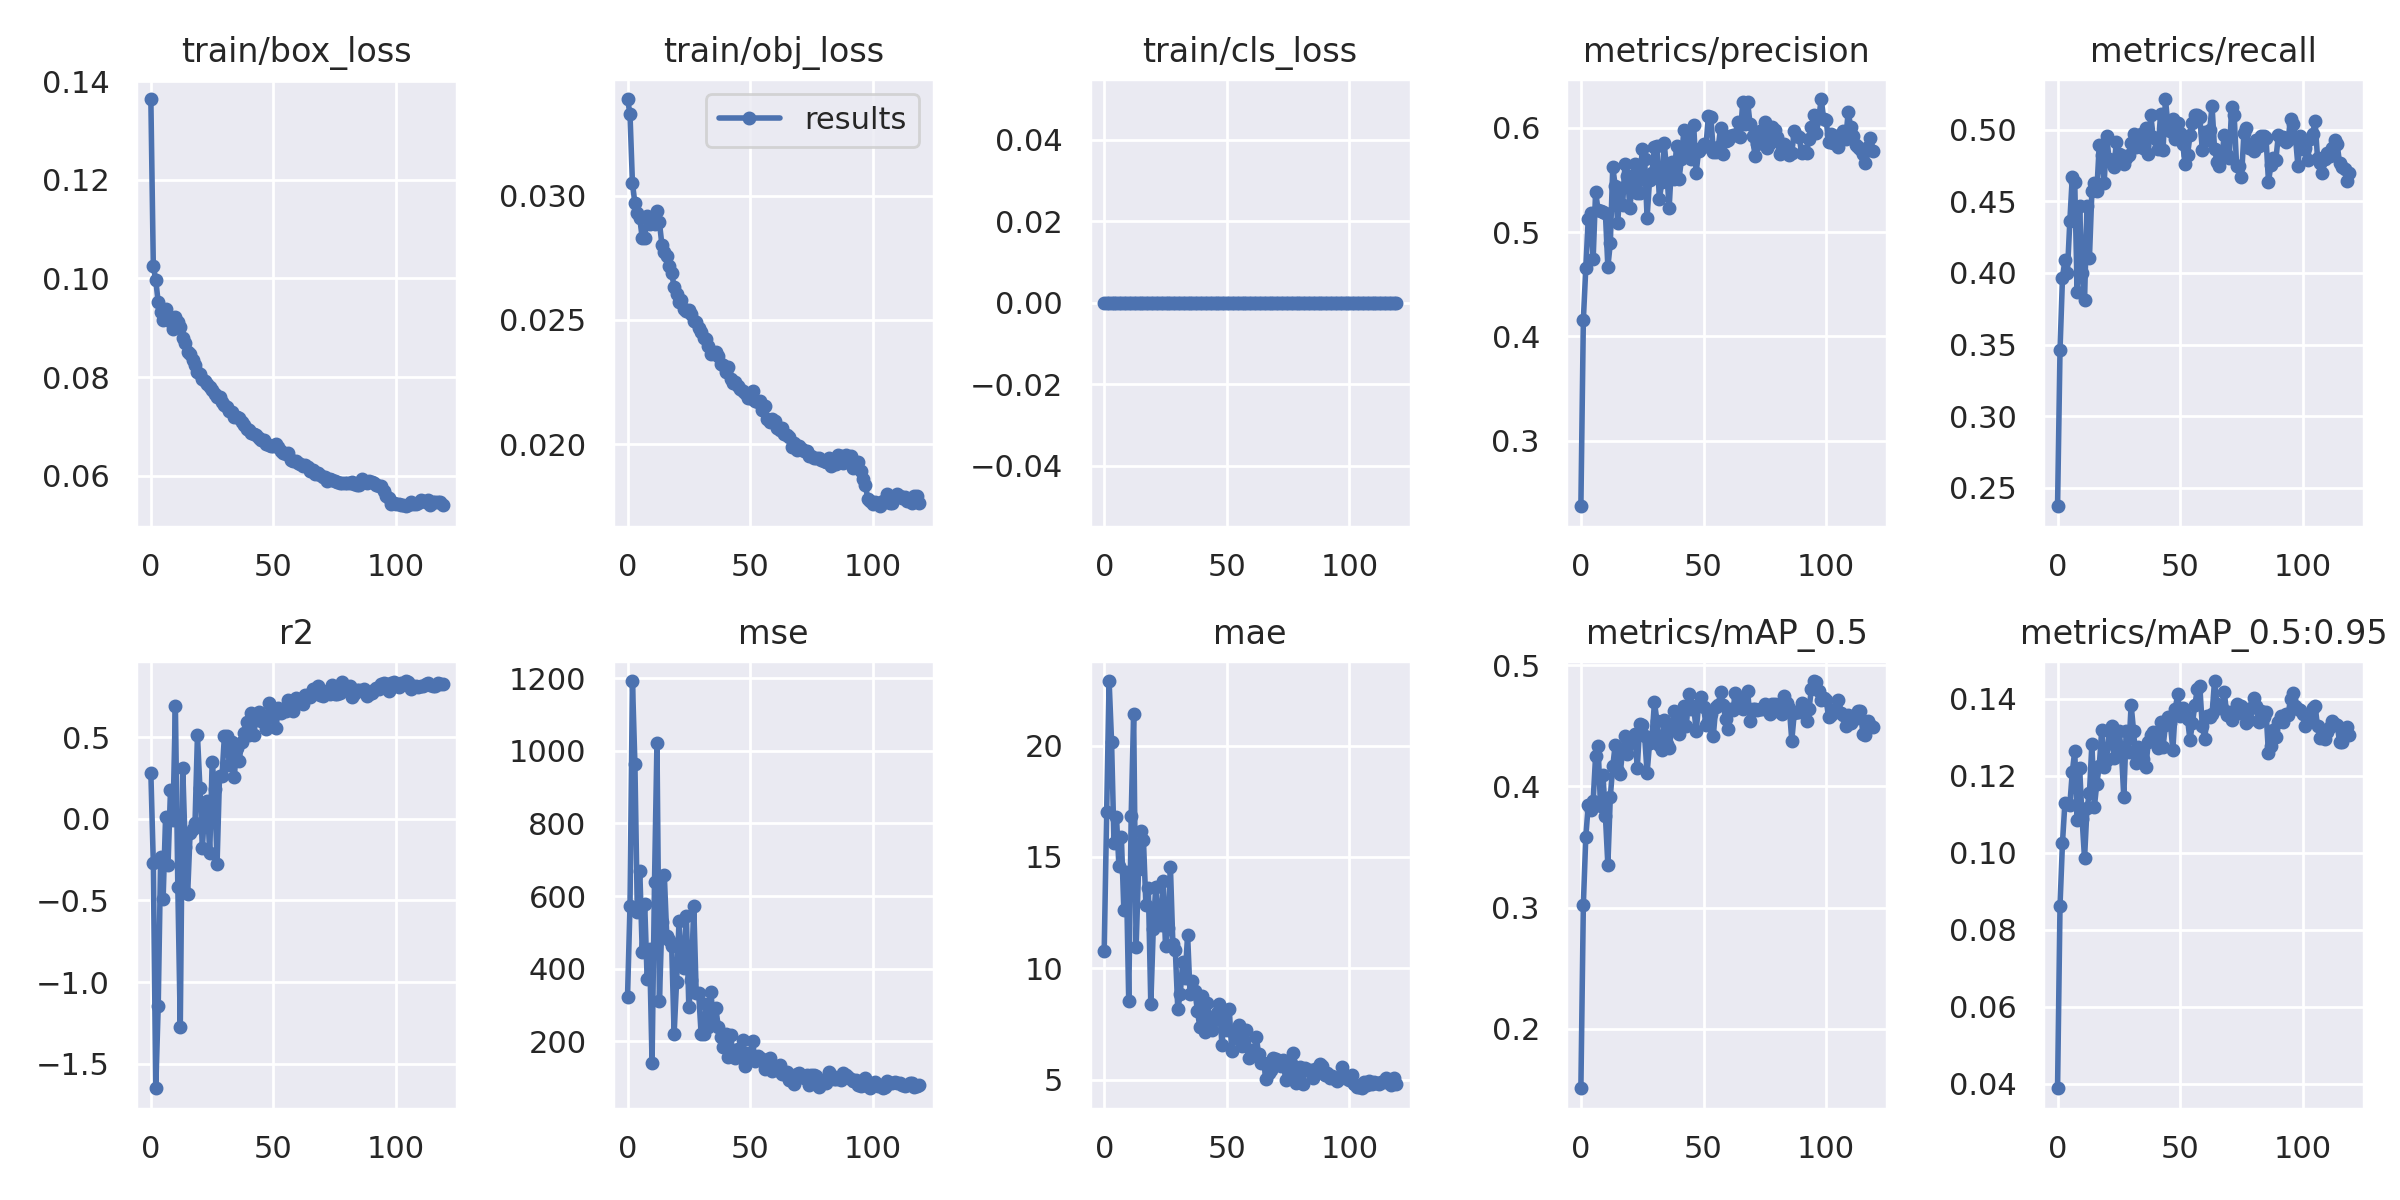

In [14]:
import IPython
from IPython.display import display
IPython.display.Image(filename='./runs/train/exp/results.png') 

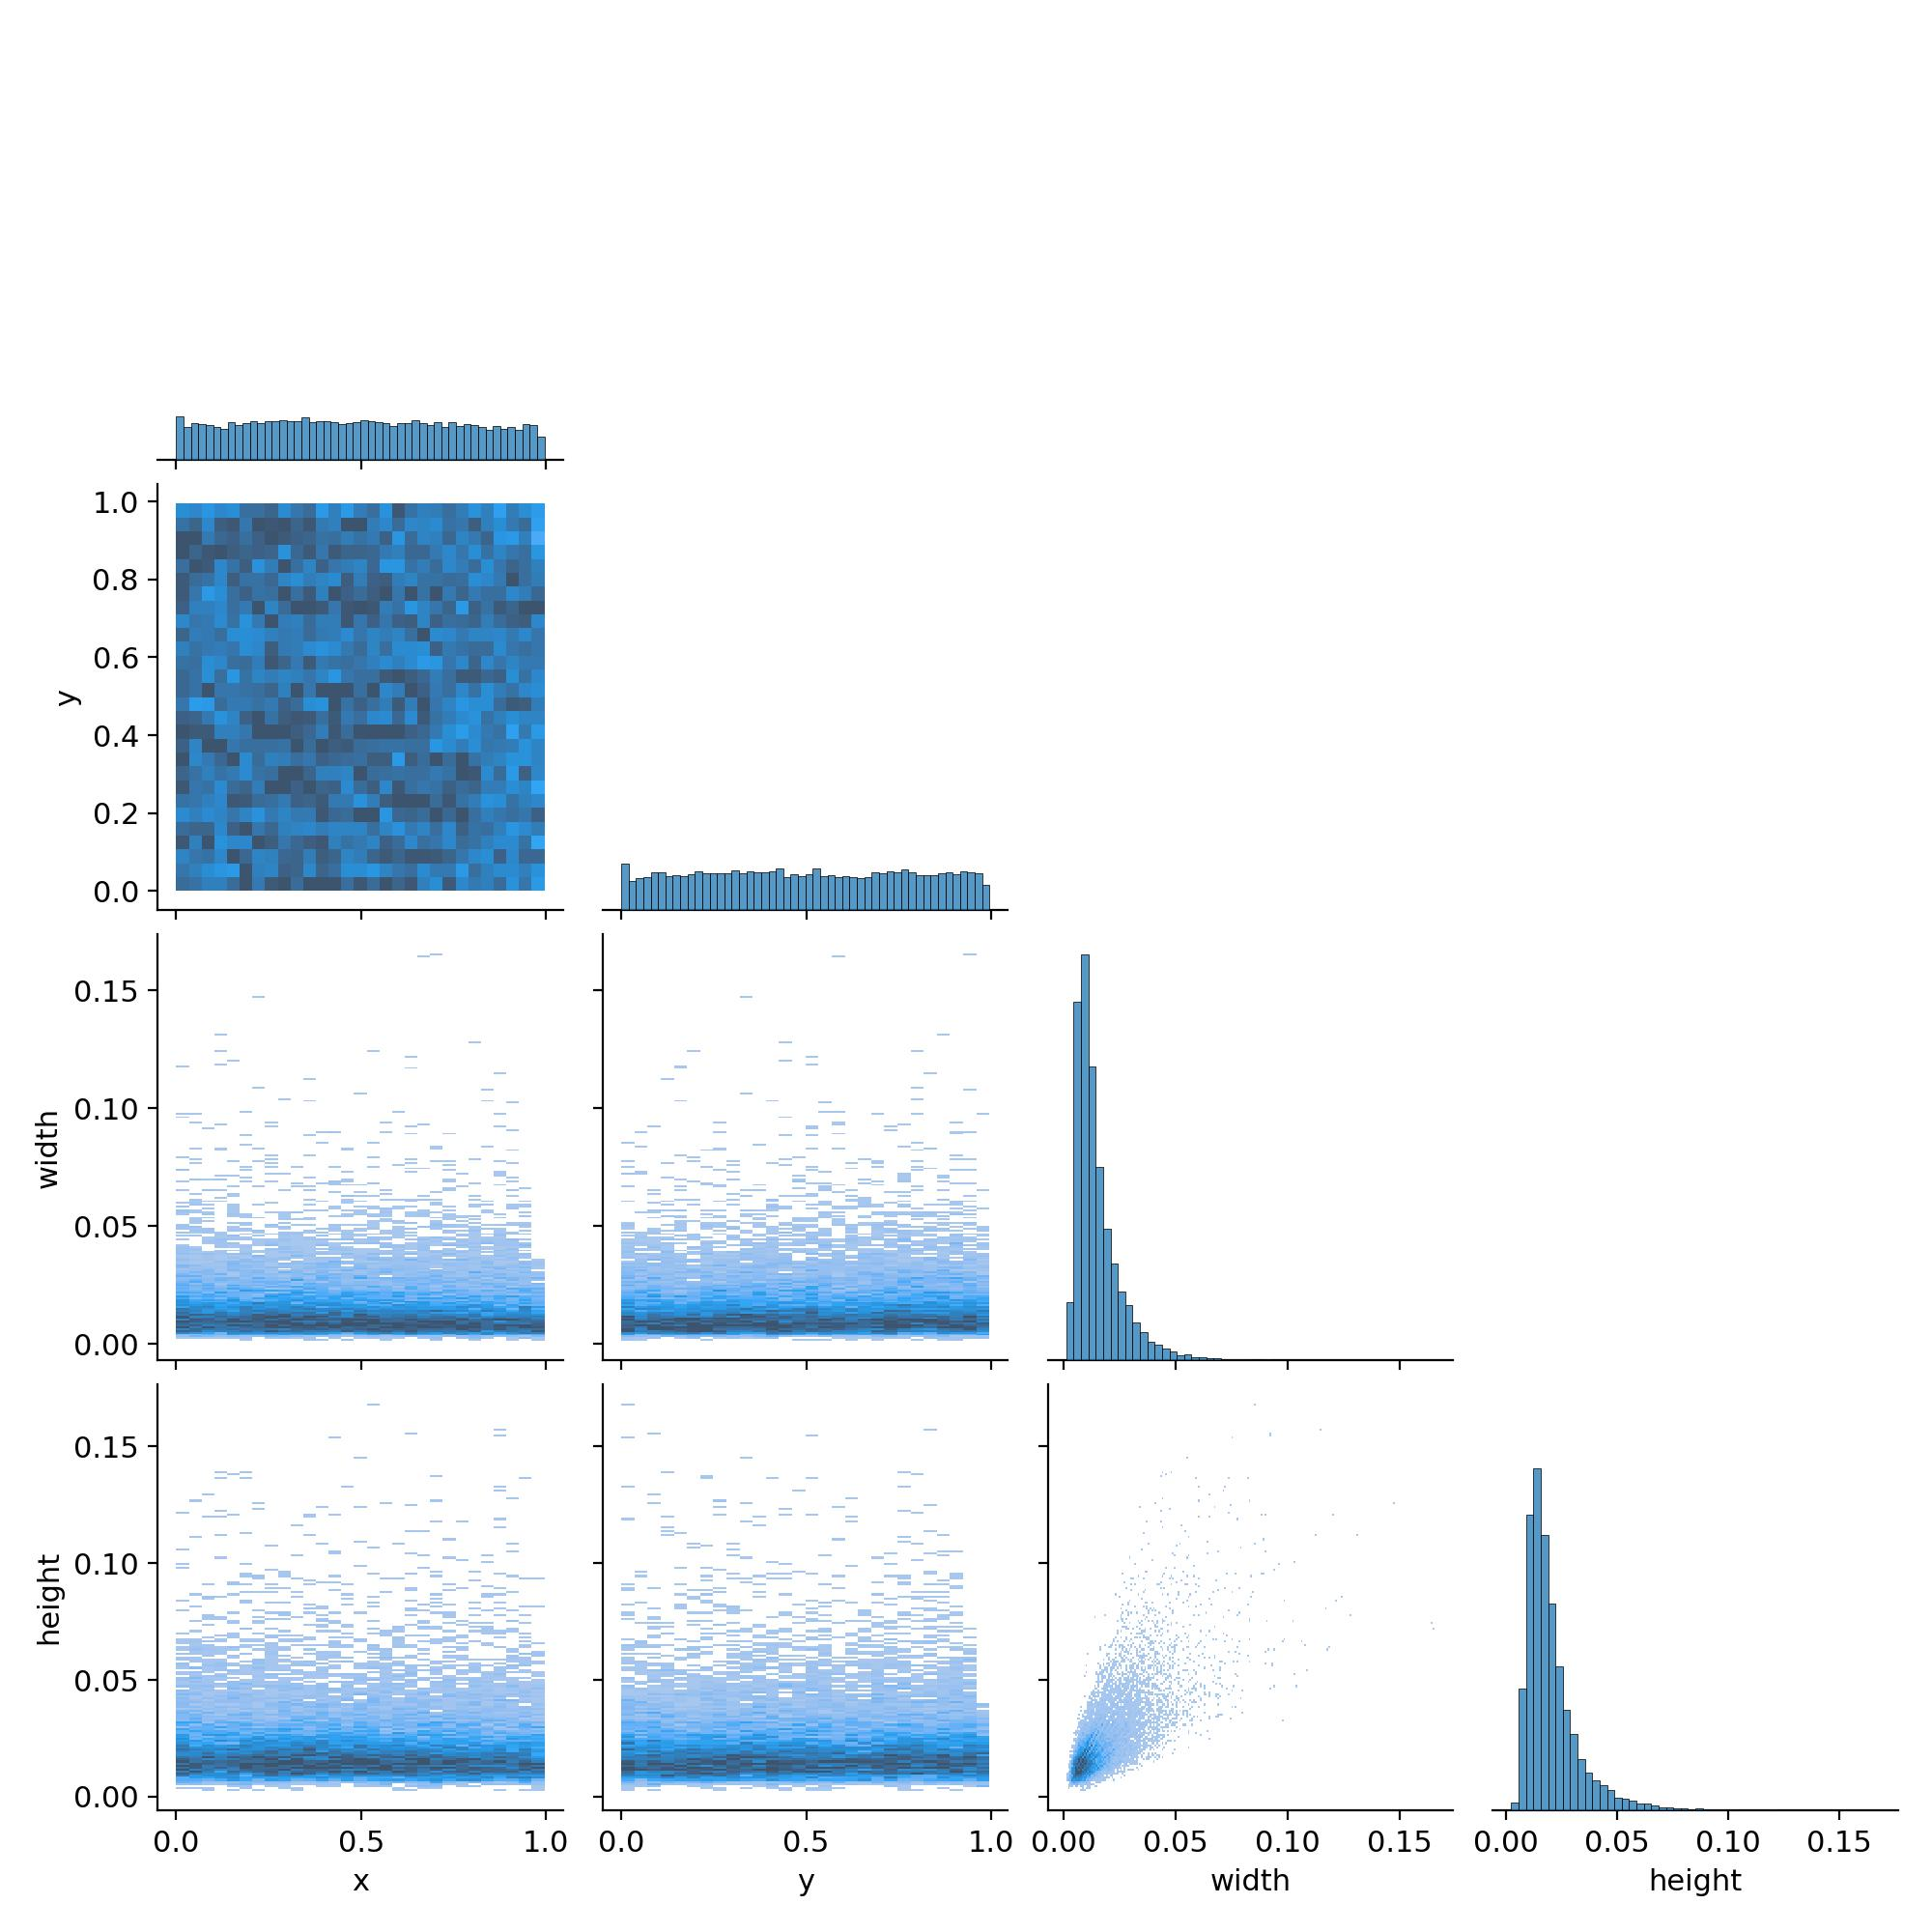

In [15]:
IPython.display.Image(filename='./runs/train/exp/labels_correlogram.jpg') 

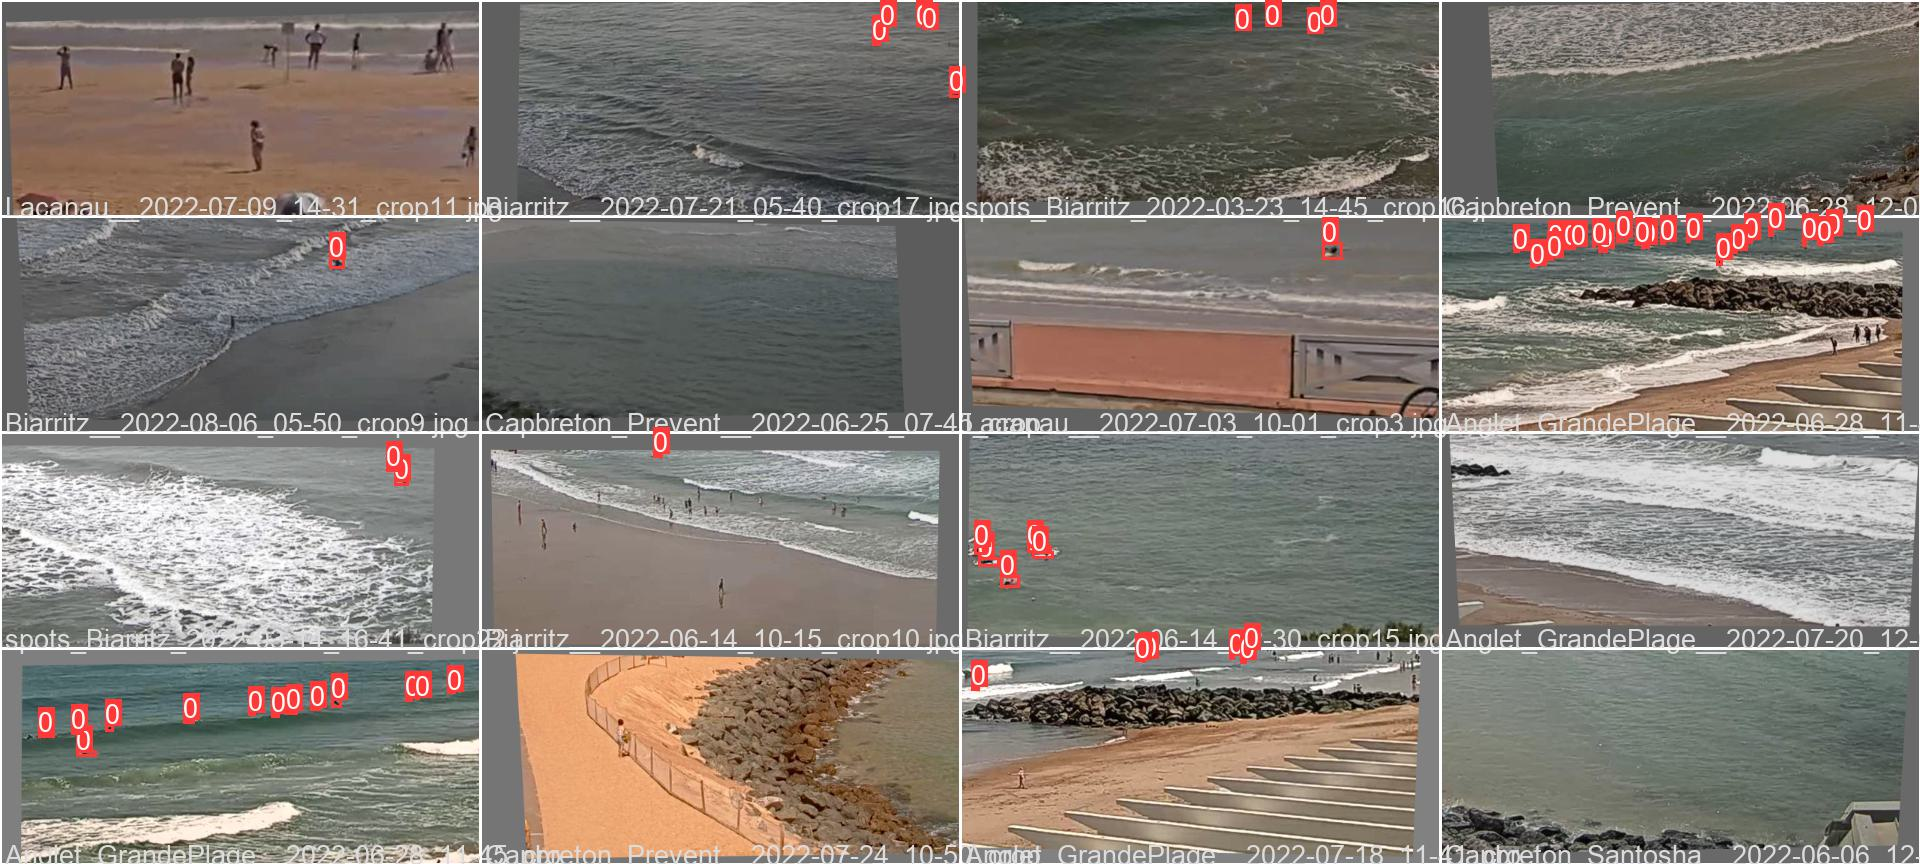

In [16]:
IPython.display.Image(filename='./runs/train/exp/train_batch0.jpg') 

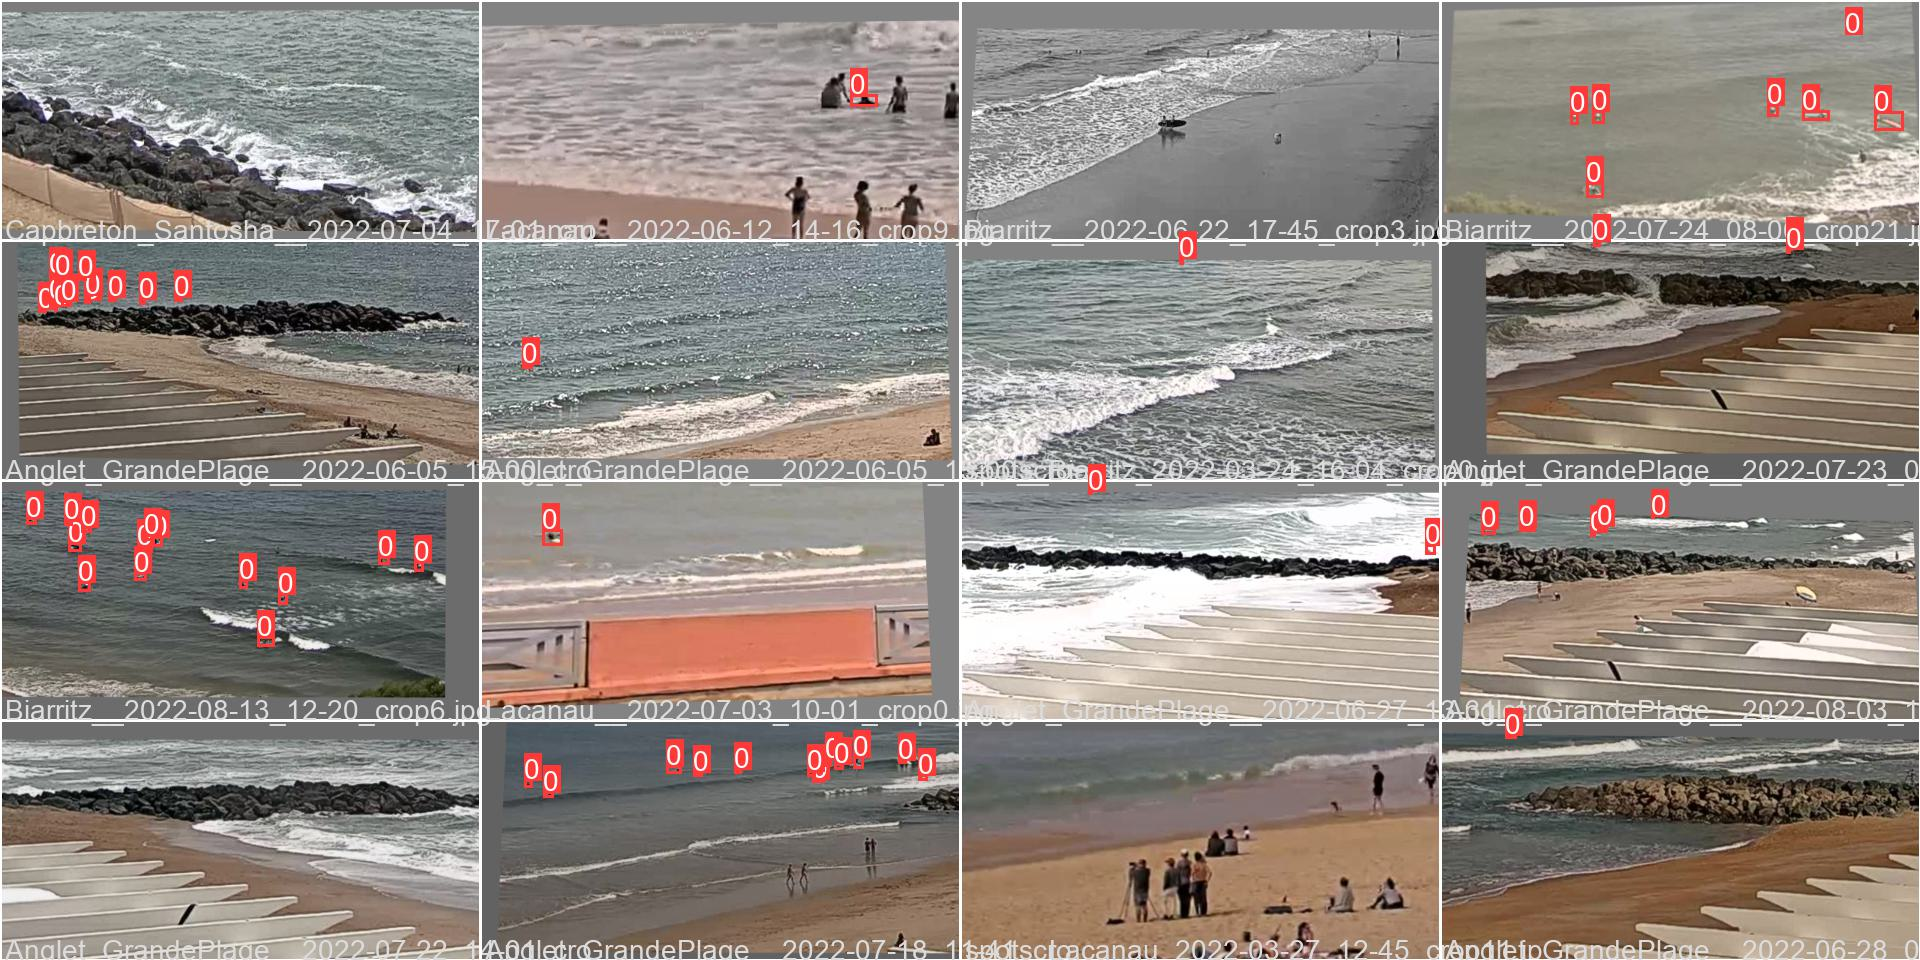

In [17]:
IPython.display.Image(filename='./runs/train/exp/train_batch1.jpg') 

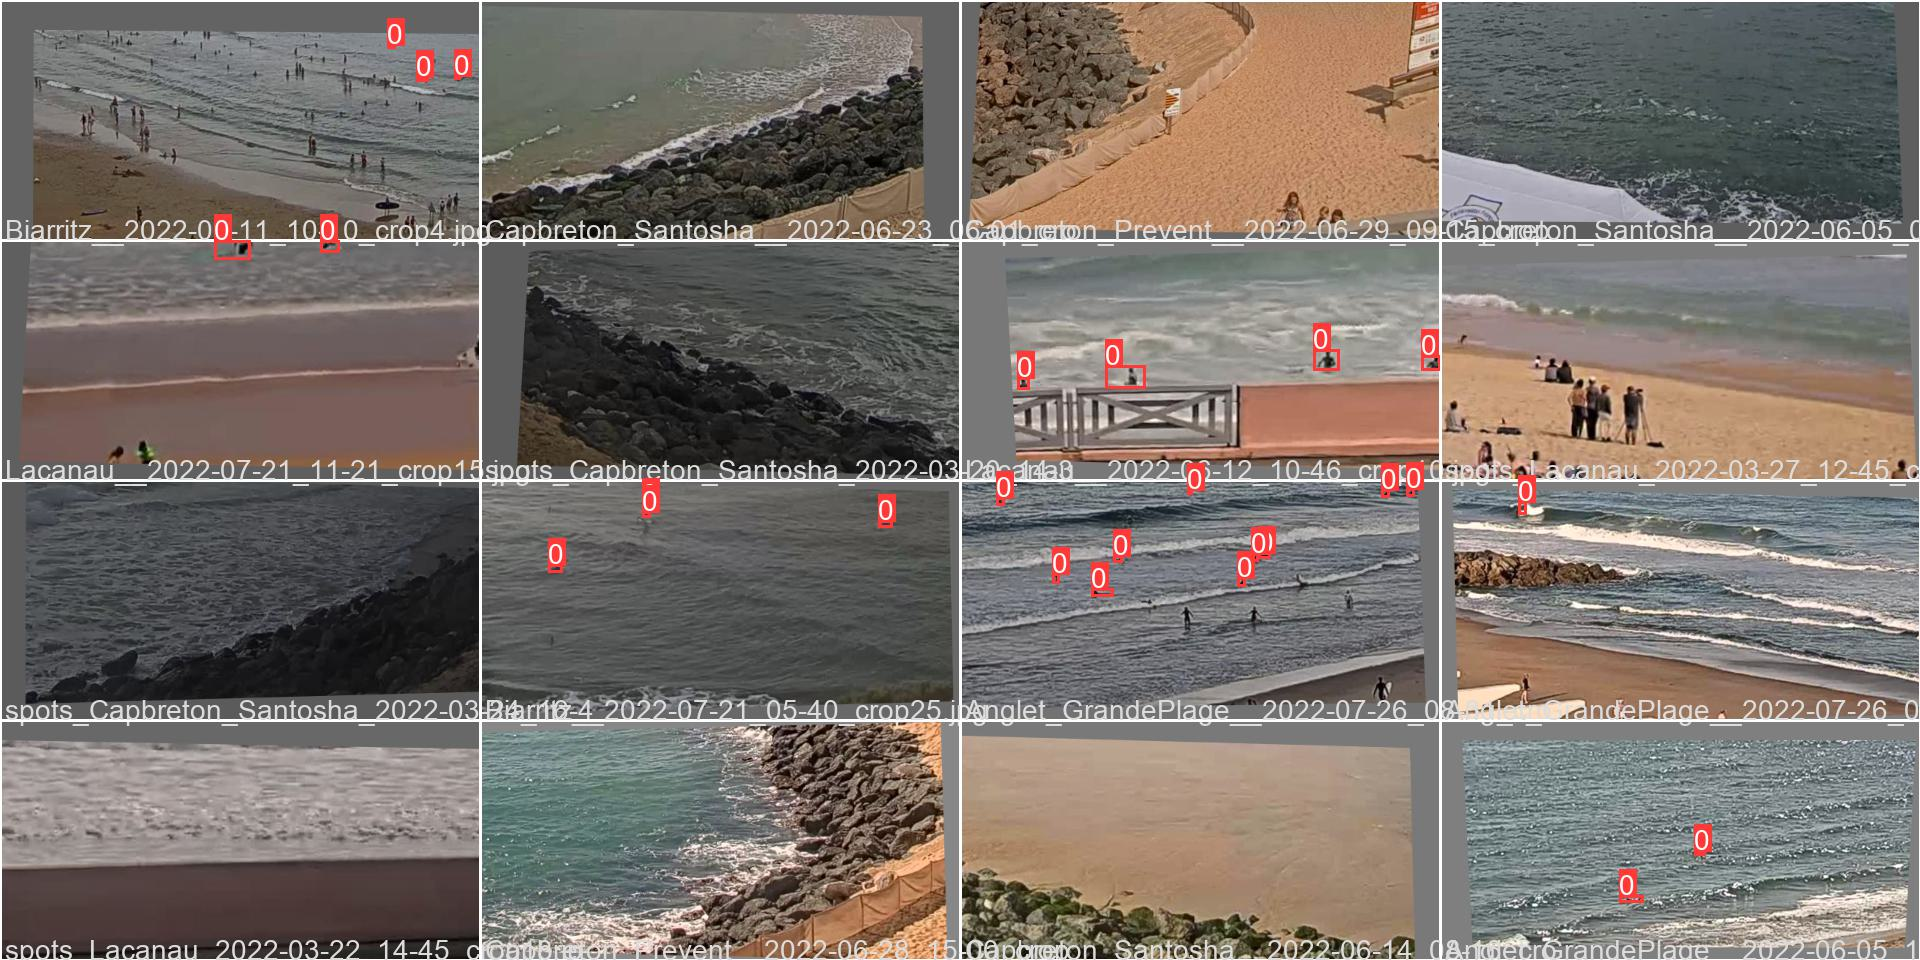

In [18]:
IPython.display.Image(filename='./runs/train/exp/train_batch2.jpg') 

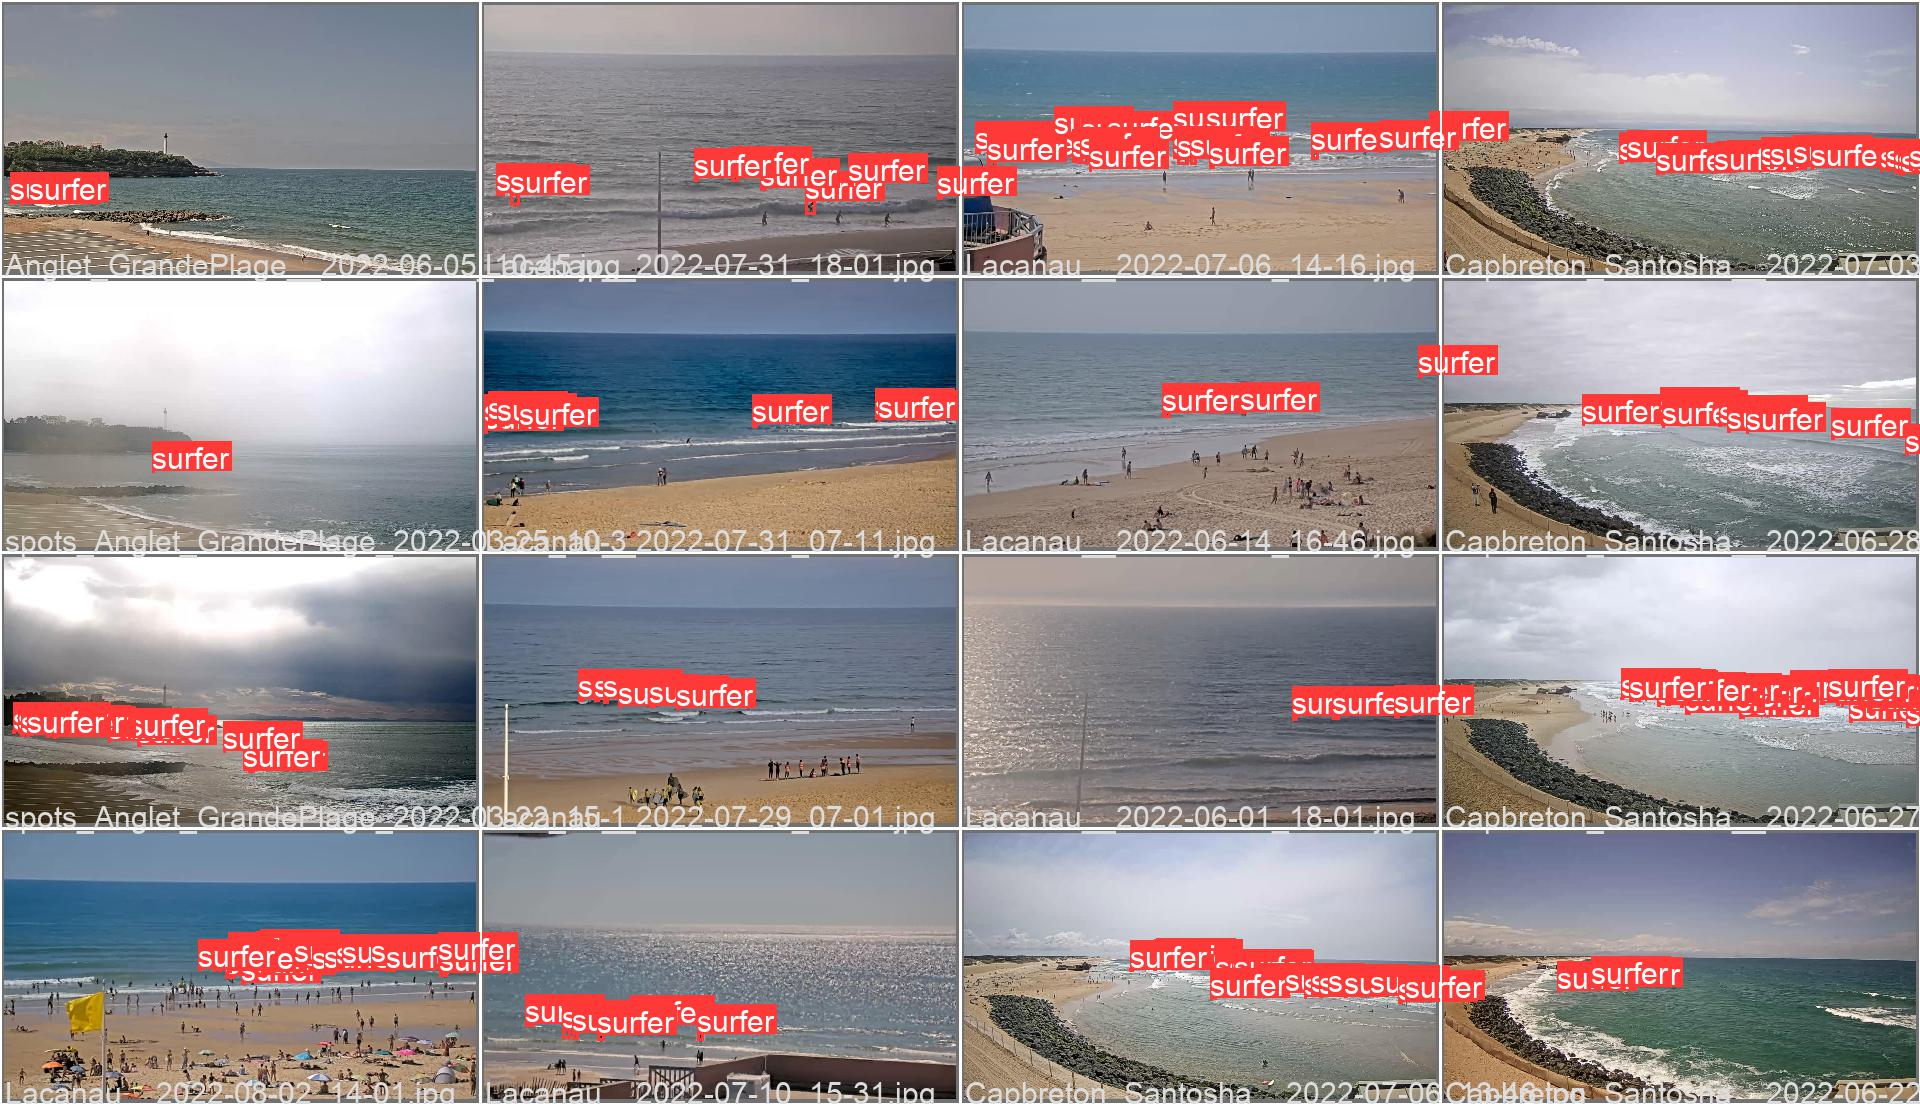

In [19]:
IPython.display.Image(filename='./runs/train/exp/val_batch0_labels.jpg') 

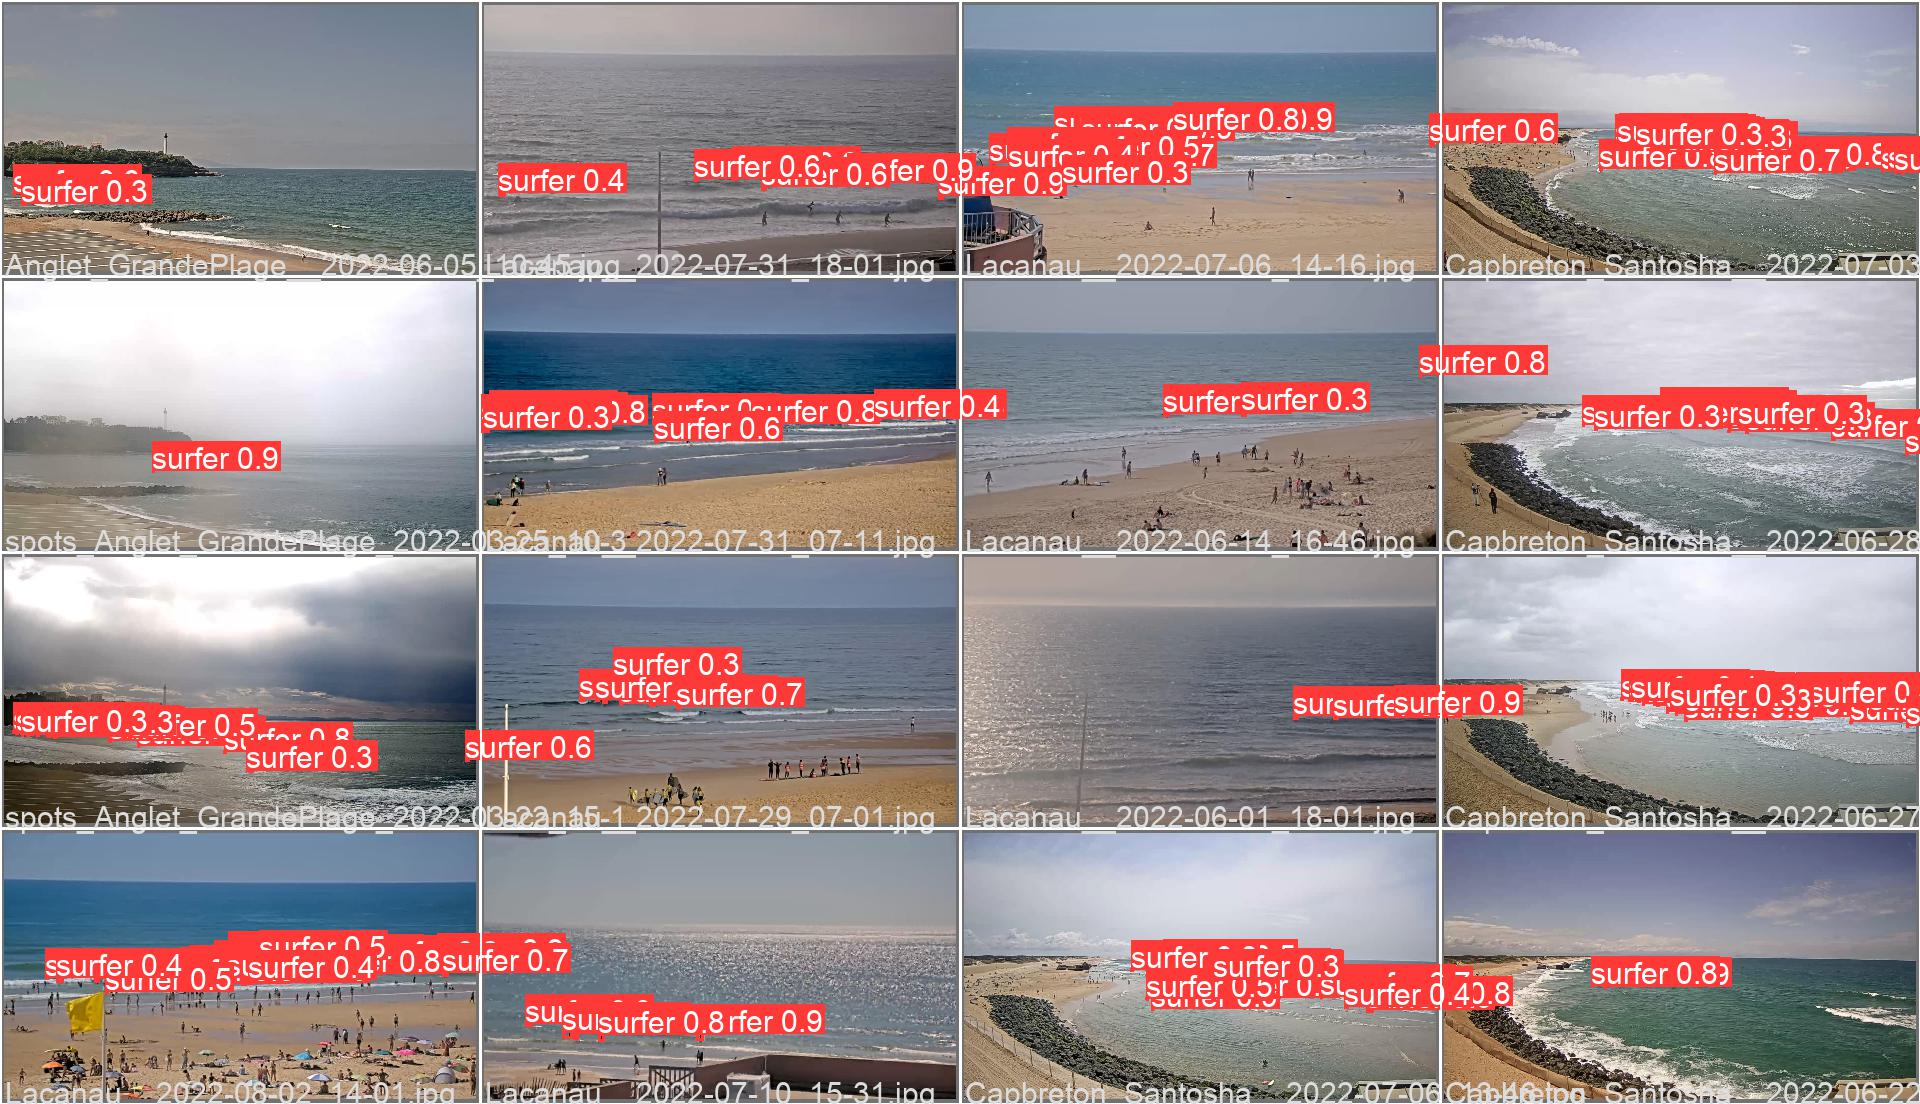

In [20]:
IPython.display.Image(filename='./runs/train/exp/val_batch0_pred.jpg') 

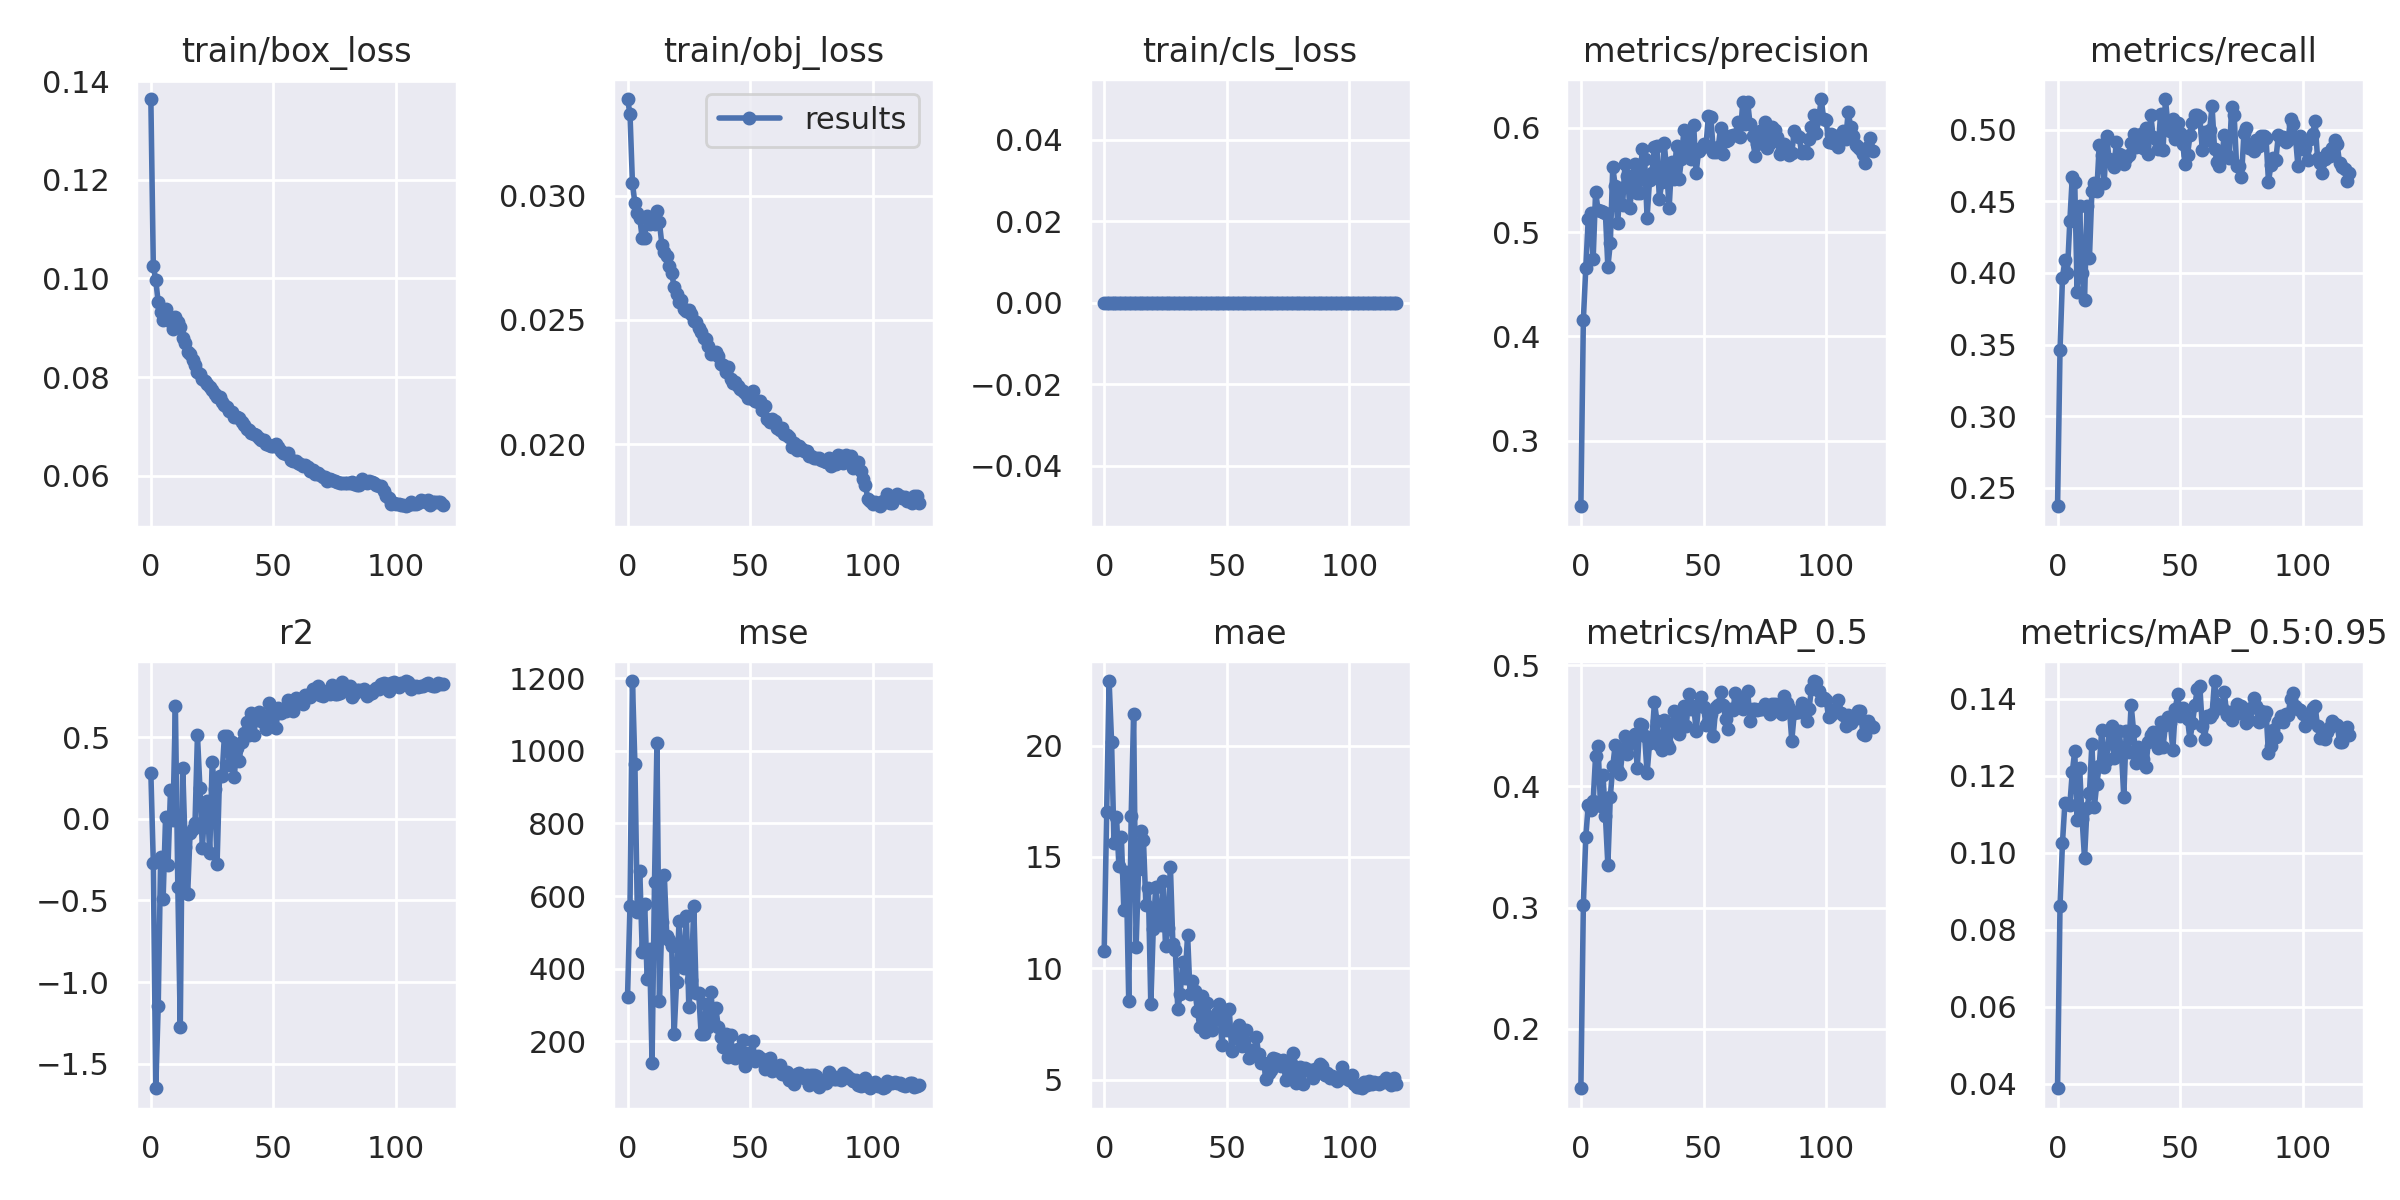

In [21]:
IPython.display.Image(filename='./runs/train/exp/results.png') 

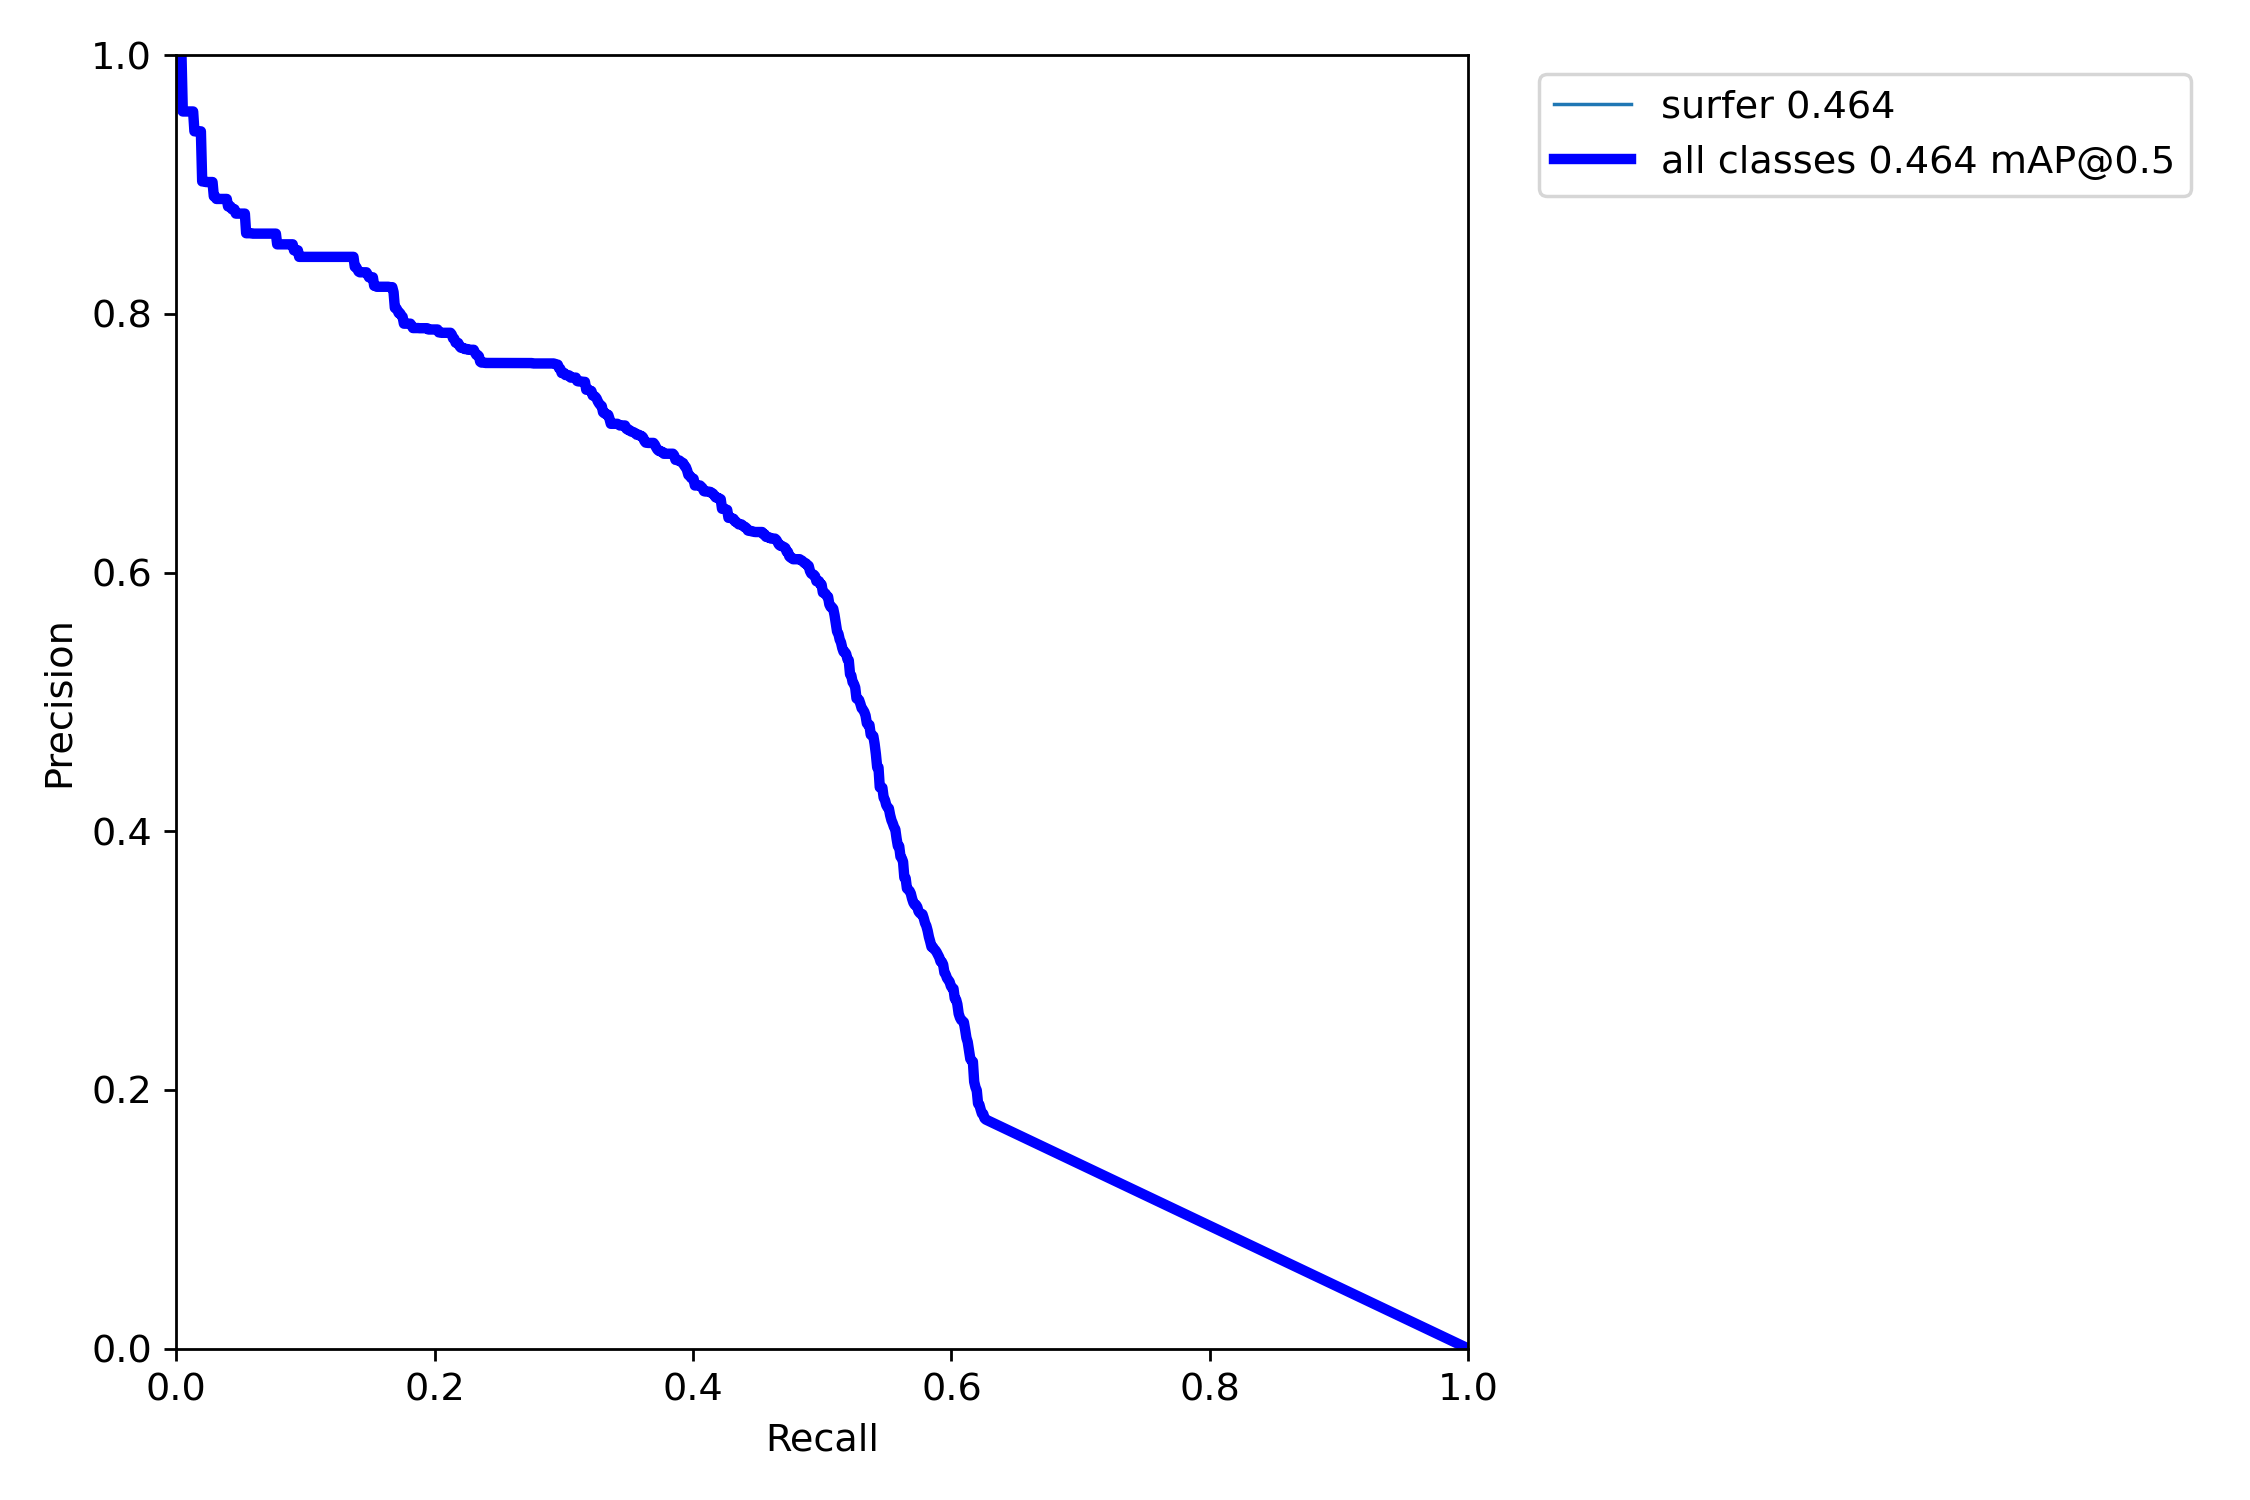

In [22]:
IPython.display.Image(filename='./runs/train/exp/PR_curve.png') 

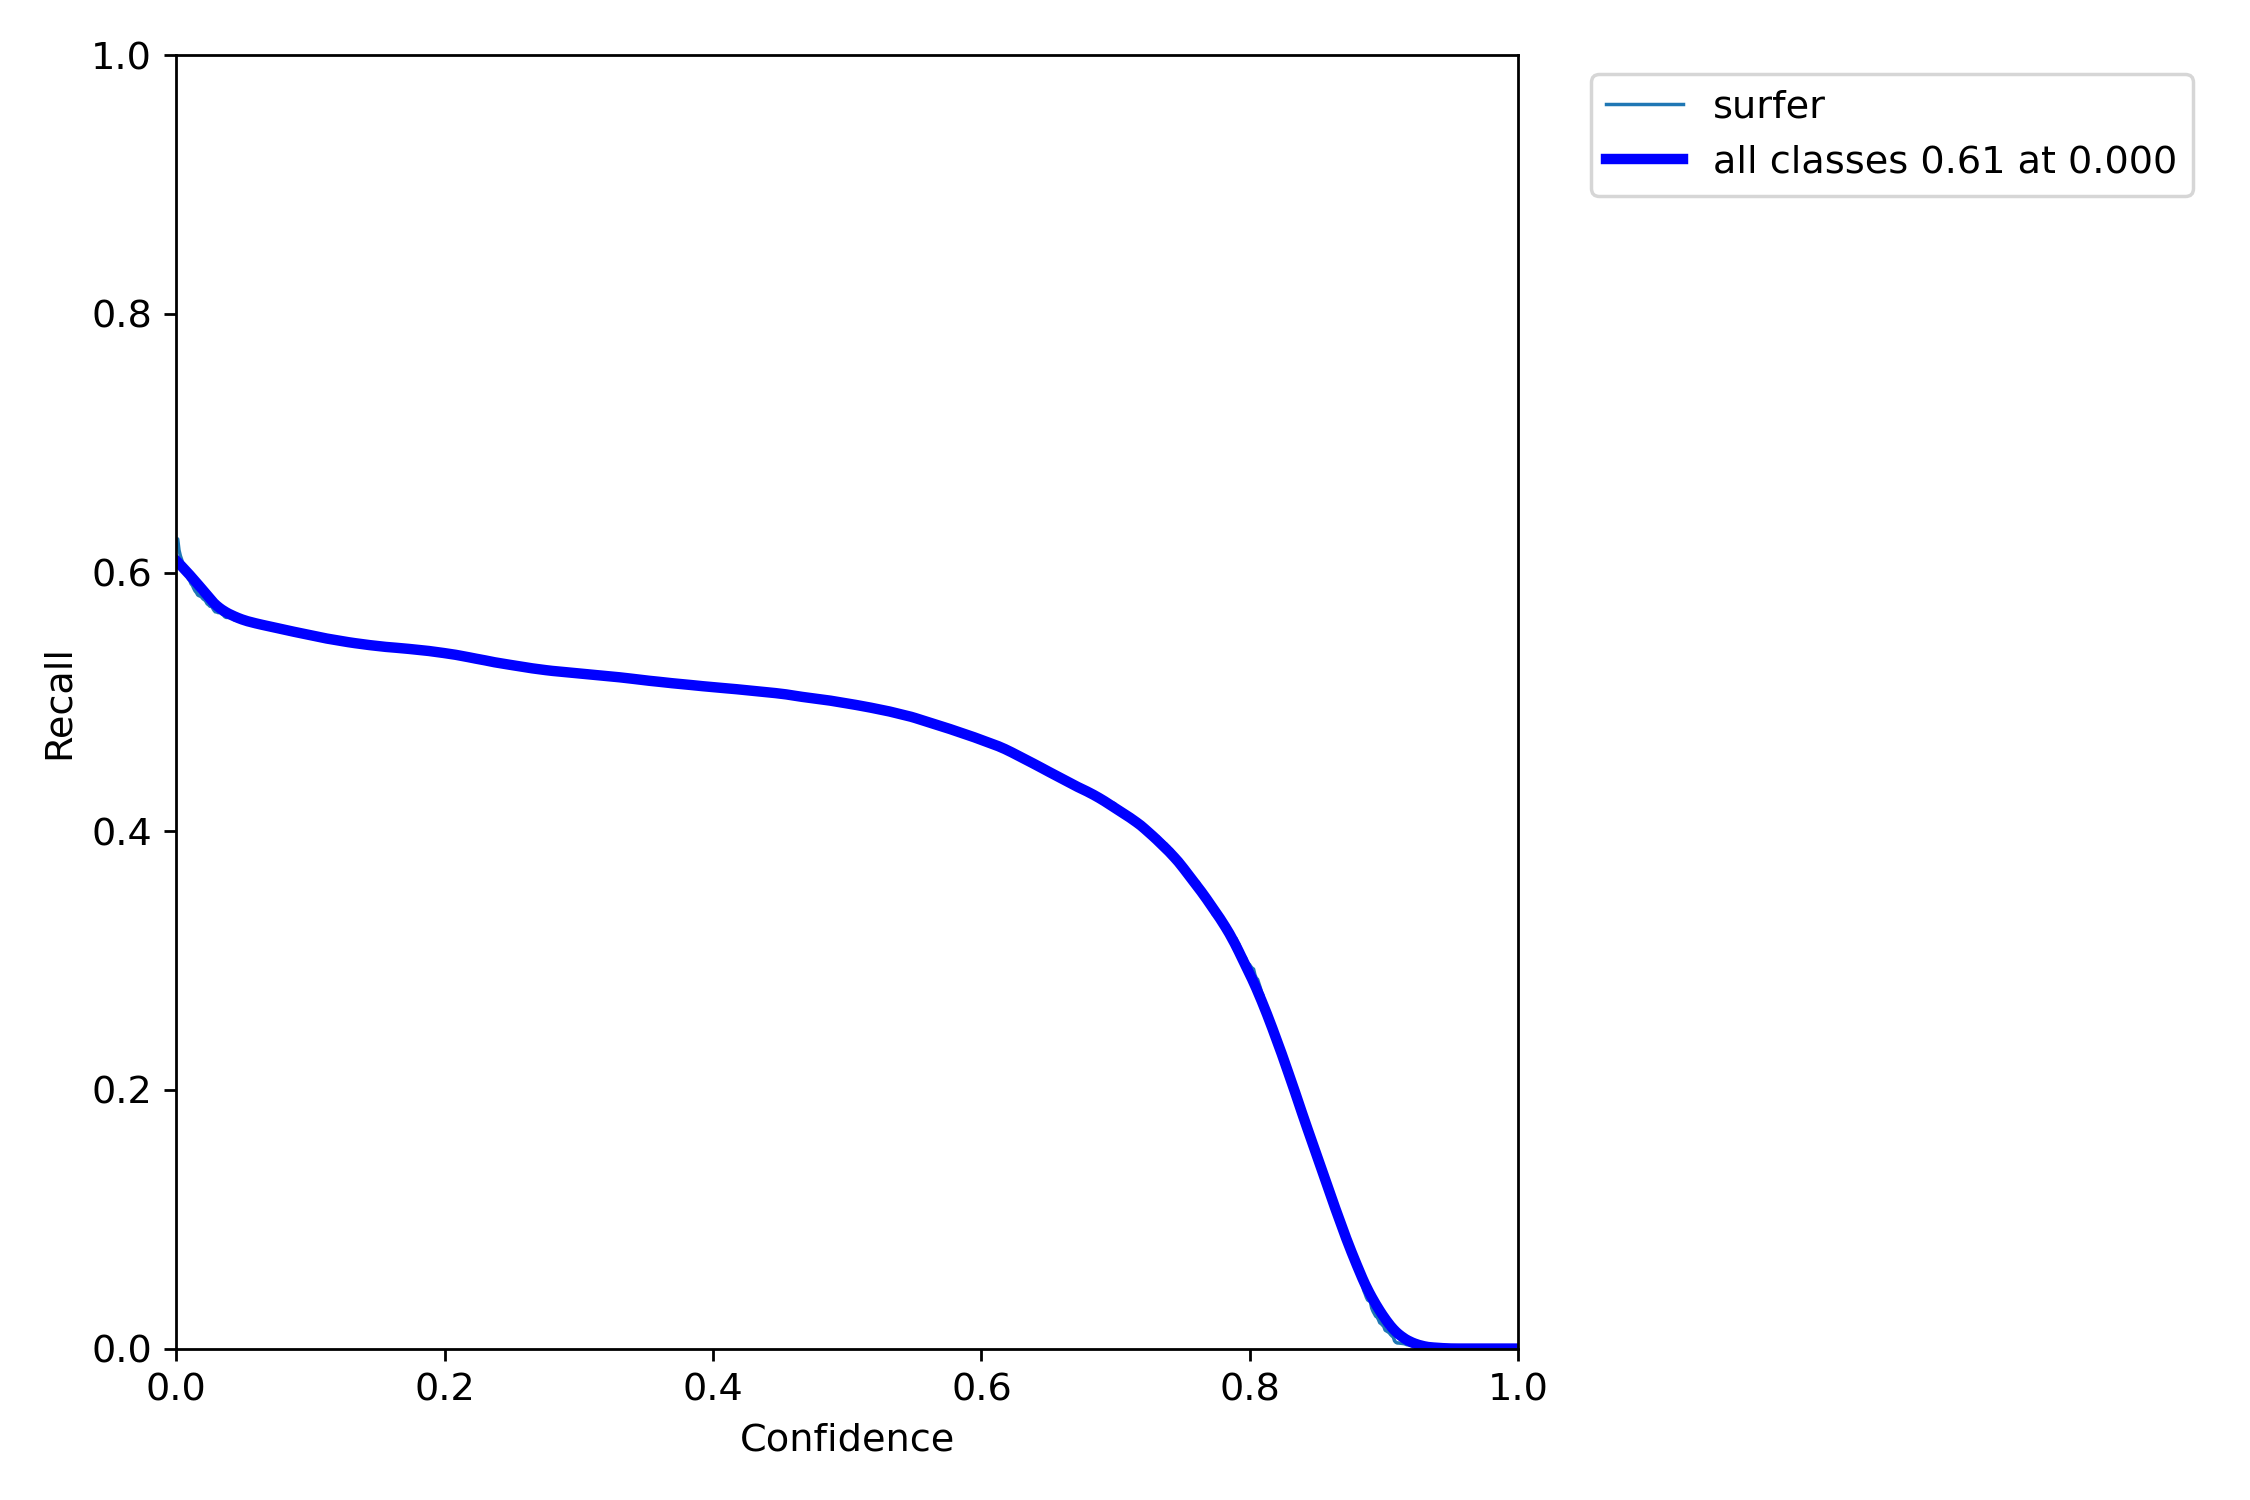

In [23]:
IPython.display.Image(filename='./runs/train/exp/R_curve.png') 

In [24]:
import torch
import glob
from PIL import Image
import pandas as pd
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

files = [f for f in glob.glob("data/surfers-detection/images/val/*.jpg", recursive=True) if os.path.getsize(f) > 0]
bs = 32
model = torch.hub.load('./', 'custom', path='runs/train/exp/weights/best.pt', source='local')
model.conf = 0.4  # NMS confidence threshold
        
save_every = 2
all_preds = None
for i in range(1 + int(len(files) / bs)):
    batch_files = [f for f in files[i * bs : np.min([(i + 1) * bs, len(files) - 1])]]
    
    imgs = [Image.open(f).resize((1920, 1080)) for f in batch_files]
            
    results = model(imgs, size=1920)  # includes NMS
                   
    for j, pred in enumerate(results.pandas().xyxy):
        pred['file'] = batch_files[j].replace("data/", "")
        if all_preds is None:
            all_preds = pred
        else:
            all_preds = pd.concat([all_preds, pred])
    
    if i % save_every == 0:
        all_preds.to_csv("all_preds.csv", index=False)
                    
    results.save()

all_preds.to_csv("all_preds.csv", index=False)

YOLOv5 🚀 2022-8-19 Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
Adding AutoShape... 
Saved 32 images to runs/detect/exp
Saved 32 images to runs/detect/exp2
Saved 26 images to runs/detect/exp3
